<a href="https://colab.research.google.com/github/CorsiIsa/Deep-And-Reinforcement-Learning/blob/master/multilayer_perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classificando diferentes tipos de semente de abóbora 🎃🌱

A base de dados **"SementesAbobora.xlsx"** possui um estudo foi realizado nos dois tipos de sementes de abóbora mais importantes e de qualidade, **“Ürgüp Sivrisi”** e **“Çerçevelik”**, geralmente cultivadas nas regiões de Ürgüp e Karacaören na Turquia.

Muitas espécies de sementes têm semelhanças visuais, o que torna a classificação manual difícil e sujeita a erros. Redes neurais podem ser treinadas para identificar padrões que não são facilmente perceptíveis pelo olho humano, aumentando a precisão da classificação.

### Features

- Perímetro
- Maior_Eixo_Comprimento
- Comprimento_Eixo_Menor
- Área_Convexa
- Equiv_Diâmetro
- Excentricidade
- Solidez
- Extensão
- Redondeza
- Proporcao
- Compacidade

### Target
Classes:
 ((A)Çerçevelik, (B)Ürgüp Sivrisi)

# Importando as bibliotecas

In [23]:
import pandas as pd
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np


import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import metrics
from keras.optimizers import Adam
from keras.metrics import Precision
from tqdm.keras import TqdmCallback

from sklearn.metrics import classification_report

# Importando nosso df

In [2]:
path = 'SementesAbobora.xlsx'
df = pd.read_excel(path)

# Análise exploratória

In [3]:
df.head()

,Area,Perímetro,Maior_Eixo_Comprimento,Comprimento_Eixo_Menor,Área_Convexa,Equiv_Diâmetro,Excentricidade,Solidez,Extensão,Redondeza,Proporcao,Compacidade,Class
0,56276,888.242,326.1485,220.2388,56831,267.6805,0.7376,0.9902,0.7453,0.8963,1.4809,0.8207,(A) Çerçevelik
1,76631,1068.146,417.1932,234.2289,77280,312.3614,0.8275,0.9916,0.7151,0.8440,1.7811,0.7487,(A) Çerçevelik
2,71623,1082.987,435.8328,211.0457,72663,301.9822,0.8749,0.9857,0.7400,0.7674,2.0651,0.6929,(A) Çerçevelik
3,66458,992.051,381.5638,222.5322,67118,290.8899,0.8123,0.9902,0.7396,0.8486,1.7146,0.7624,(A) Çerçevelik
4,66107,998.146,383.8883,220.4545,67117,290.1207,0.8187,0.9850,0.6752,0.8338,1.7413,0.7557,(A) Çerçevelik


In [4]:
df.shape

(2500, 13)

Conseguimos notar que a nossa base esta ordenada, precisamos embaralhar nossos dados utilizando a função ***shuffle***

In [5]:
df = shuffle(df)

In [6]:
df.head()

,Area,Perímetro,Maior_Eixo_Comprimento,Comprimento_Eixo_Menor,Área_Convexa,Equiv_Diâmetro,Excentricidade,Solidez,Extensão,Redondeza,Proporcao,Compacidade,Class
2256,107364,1313.814,544.6092,251.7529,108062,369.7298,0.8867,0.9935,0.6605,0.7816,2.1633,0.6789,(B) Ürgüp Sivrisi
1287,63159,949.663,361.8204,223.0287,63663,283.5781,0.7874,0.9921,0.7082,0.8800,1.6223,0.7838,(A) Çerçevelik
780,80009,1096.173,423.2968,241.3410,80890,319.1718,0.8215,0.9891,0.6990,0.8367,1.7539,0.7540,(A) Çerçevelik
290,90072,1172.800,467.6129,245.9946,90812,338.6491,0.8504,0.9919,0.6978,0.8229,1.9009,0.7242,(A) Çerçevelik
988,97138,1189.701,457.4477,271.1058,97869,351.6816,0.8055,0.9925,0.6931,0.8624,1.6873,0.7688,(A) Çerçevelik


Agora precisamos verificar o equilíbrio das nossas classes (já que temos um problema de classificação a ser resolvido).

In [7]:
df['Class'].value_counts()

,count
Class,
(A) Çerçevelik,1300
(B) Ürgüp Sivrisi,1200


Como podemos notar, nossas bases já estão bem equilibradas.

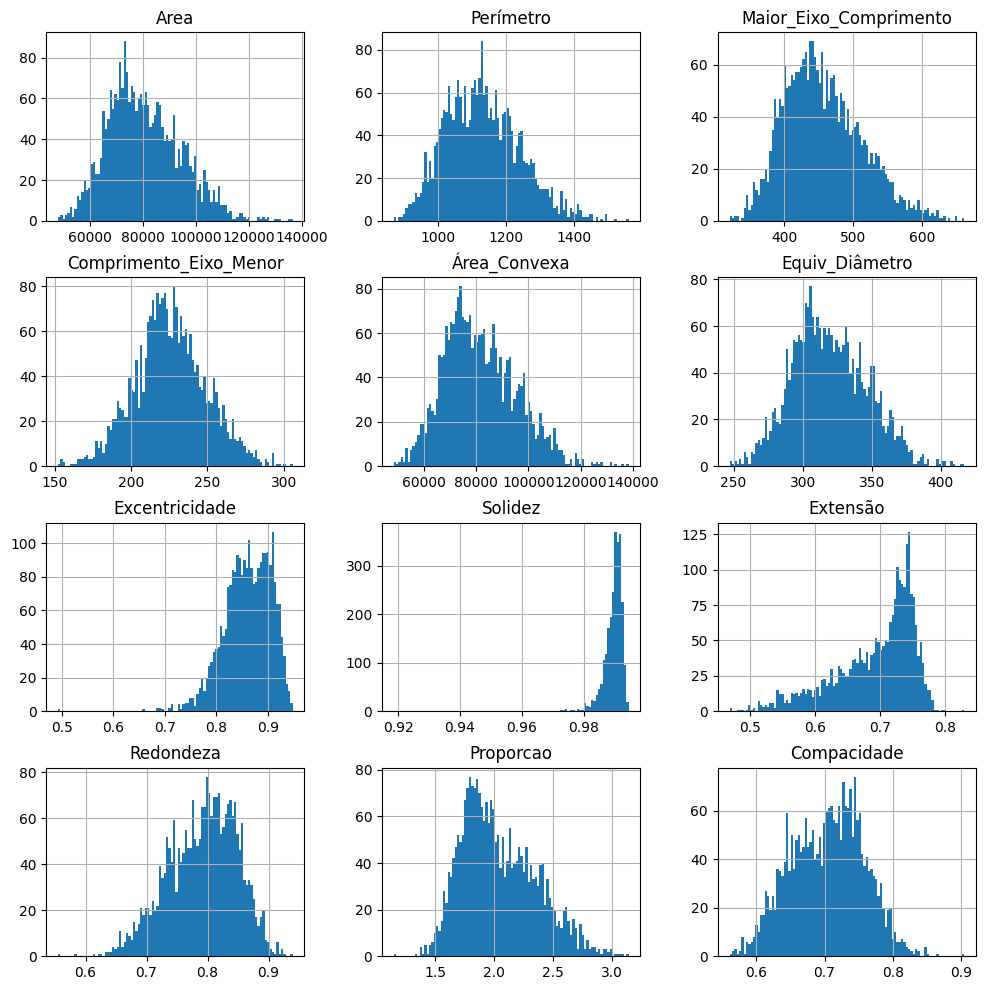

In [8]:
df.hist(bins=100, figsize=(12, 12))
plt.show()

Podemos observar que existem muitas variáveis com a distribuição quase que normal, ou seja, não temos muitos outliers exeto para as variáveis: Proporcao, Redondeza e Compacidade que possuem distribuição assimétrica muito forte.

<Axes: >

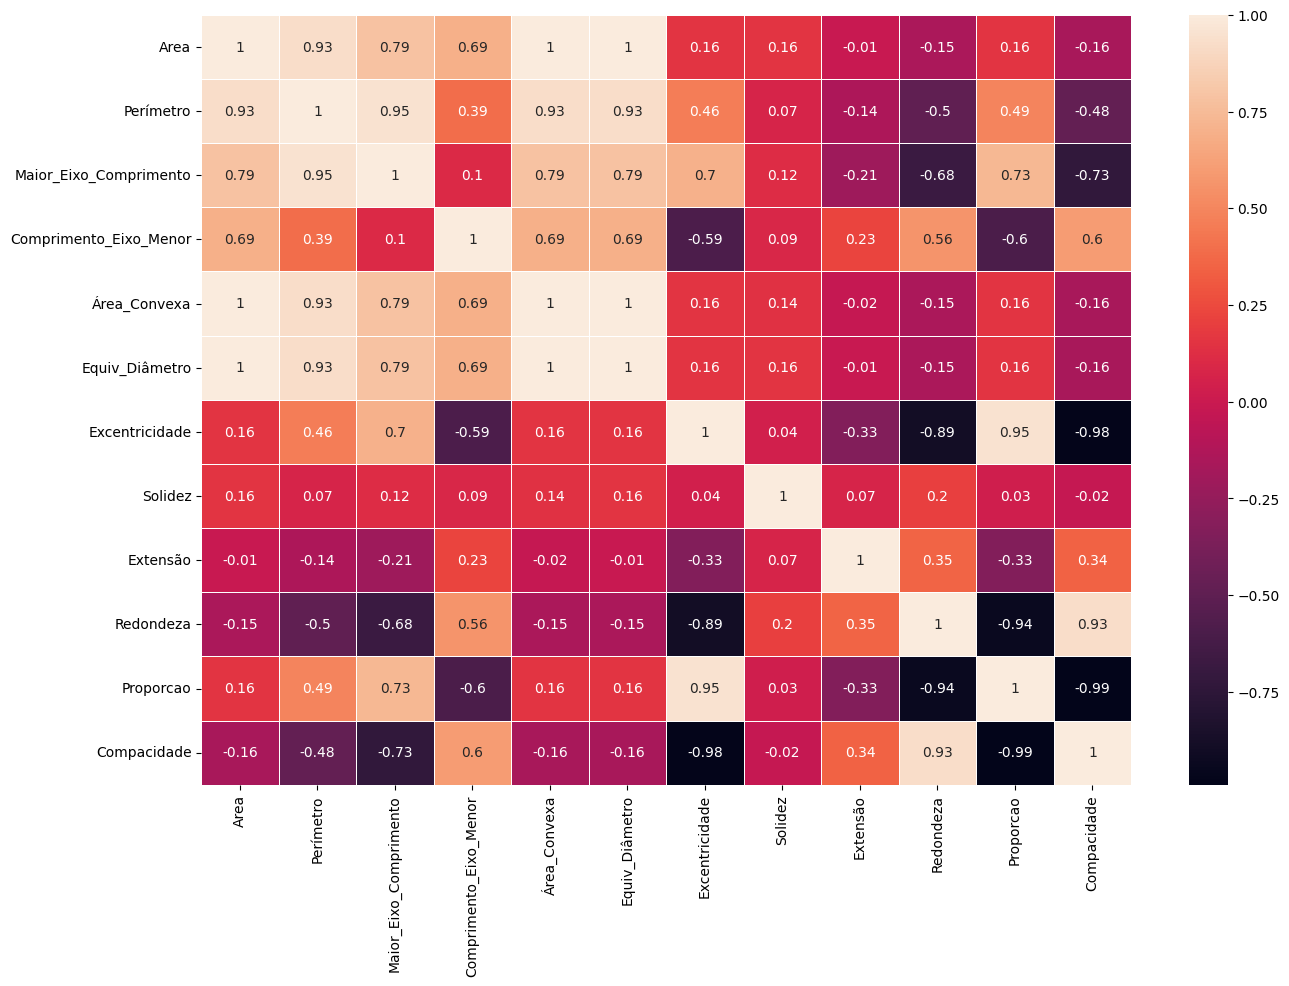

In [9]:
correlation_matrix = df.select_dtypes(include='number').corr().round(2)

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)

A correlação é muito importante para entendermos as relações das variáveis (ou seja, a associação entre duas variáveis). Podemos identificar aqui que temos variáveis altamente correlacionadas e sabemos que isso pode ser um problema para o modelo.

Area, Area_convexa, Equiv_Diâmetro e Maior_Eixo_Comprimento possuem correlação maior que **0.90** quando analisadas com a variável **Perímetro**, isso se deve pelo motivo que que todas essas variáveis são relacionadas ao tamanho das sementes. Já sabemos que não precisamos colocar todas no modelo.

# Validando nossa target

Utilizaremos a biblioteca **LabelEncoder** para padronizar nossas variáveis.

In [10]:
le = LabelEncoder()
df.Class = le.fit_transform(df['Class'])

In [11]:
set(df['Class'])

{0, 1}

# Separando nossa base

In [12]:
X = df[['Area','Perímetro', 'Comprimento_Eixo_Menor','Excentricidade','Solidez','Extensão','Redondeza', 'Proporcao', 'Compacidade']]
y = df['Class']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Pré-processamento dos dados

Apesar de deep learning não requerer distribuições normais, é comum aplicar **técnicas de pré-processamento de dados para normalizar ou padronizar as características**. Isso pode ajudar a acelerar a convergência do treinamento da rede neural.

Utilizaremos a biblioteca **StanderScaler** para colocar nossas variáveis categóricas em uma escala de 0-1.

In [14]:
scaler = StandardScaler()
scaler.fit(X_train)
scaler.fit(X_test)

StandardScaler()

In [15]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Moldando nossas variáveis de resposta

Perceba que a nossas classes estão em um formato de estrutura de dados unidimensional (assim como uma coluna) e precisamos moldar para o formato de array -n dimensional(matriz).

O comando reshape é utilizado para reformatar a estrutura de um array multidimensional, como um tensor, que é a estrutura de dados fundamental usada em deep learning e processamento de dados em redes neurais.

In [16]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [17]:
type(y_train)

numpy.ndarray

# Montando arquitetura

In [18]:
# Semente aleatótia para manter os mesmos dados
tf.random.set_seed(7)

# Definindo entradas da rede + tamanho da batch de processamento
input_shape = X_train.shape[1]    # Variáveis de entrada
output_shape = y_train.shape[1]   # Classe preditora
batch_size = 20

# Abrindo uma sequencia de neuronios
model = models.Sequential()

# input layer
# Entrada da rede
model.add(layers.Dense(
                        batch_size
                       ,input_shape=(input_shape,)
                       ,activation='relu'))

# hidden layer
# Camada oculta
model.add(layers.Dense(
                        12
                       ,activation='relu'))

# hidden layer
# Camada oculta
model.add(layers.Dense(
                        6
                       ,activation='relu'))


# dropout layer
# Aplicando regularização
model.add(layers.Dropout(0.5))

# output layer
# Camada de saída
model.add(layers.Dense(
                        output_shape
                       ,activation='sigmoid'))

# Configurar o otimizador Adam com uma learning rate específica
# Defina a learning rate desejada
learning_rate = 0.001
otimizador = Adam(learning_rate=learning_rate)

# Compilar o modelo com o otimizador configurado
model.compile(loss='binary_crossentropy', optimizer=otimizador, metrics=['accuracy'])

# summmary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 20)             │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           252 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 537 (2.10 KB)

 Trainable params: 537 (2.10 KB)

 Non-trainable params: 0 (0.00 B)

Agora vamos executar as épocas de processamento para a rede treinar e encontrar o menor erro:

In [19]:
epoch = 100

hist = model.fit(X_train
                  ,y_train
                  ,epochs = epoch
                  ,batch_size=batch_size
                  ,shuffle=True
                  ,validation_data=(X_test, y_test)
                  ,verbose=0
                  ,callbacks=[TqdmCallback(verbose=0)]
          )


0epoch [00:00, ?epoch/s]

# Validando nosso modelo

In [20]:
acc = '{:.2%}'.format(hist.history['accuracy'][-1])
print(f"O modelo possui uma acurácia de {acc} com {epoch} epochs de processamento")

O modelo possui uma acurácia de 84.45% com 100 epochs de processamento


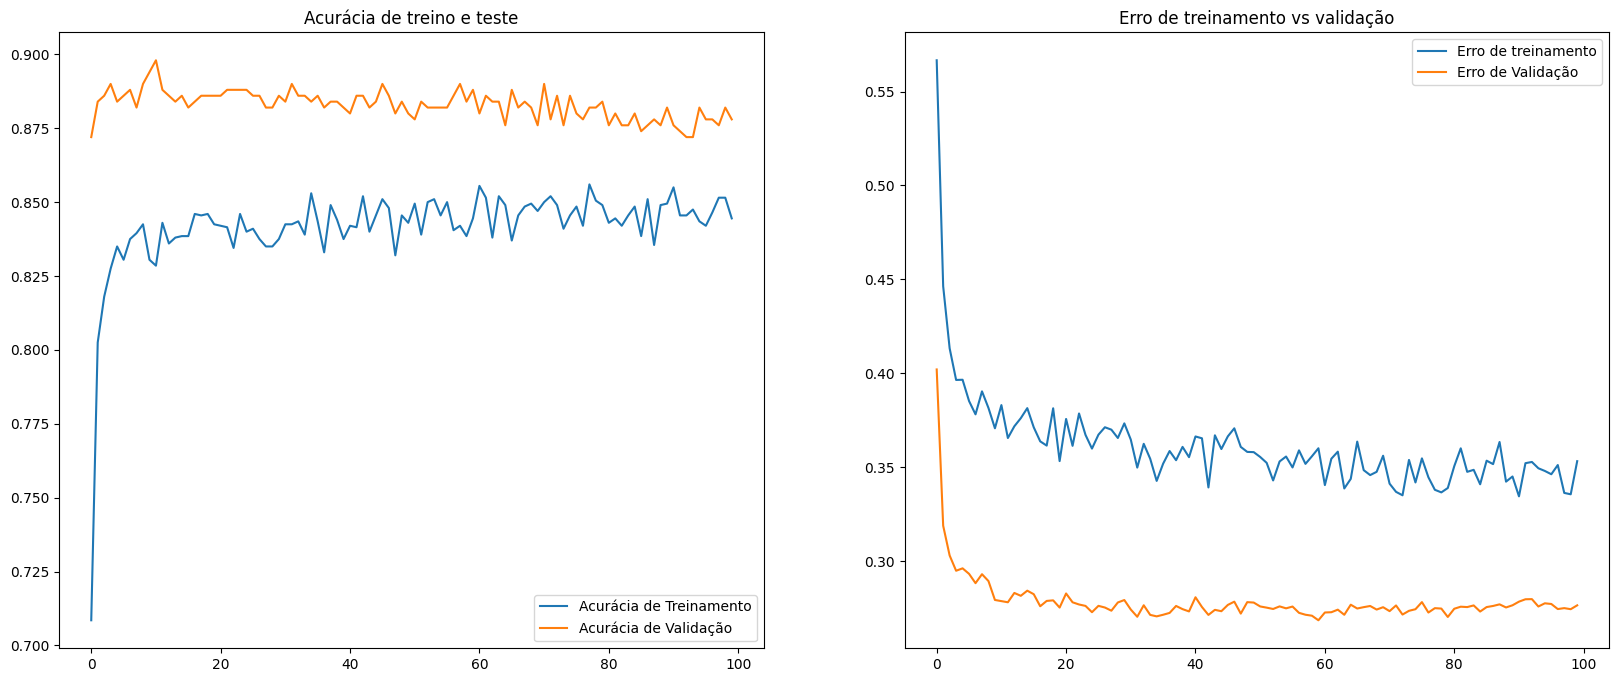

In [21]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(epoch)

# Plot Acurácia
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treinamento')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de treino e teste')

# Plot Erro de treinamento
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Erro de treinamento')
plt.plot(epochs_range, val_loss, label='Erro de Validação')
plt.legend(loc='upper right')
plt.title('Erro de treinamento vs validação')
plt.show()

In [24]:
y_pred = model.predict(X_test)
y_pred_class = [round(x[0]) for x in y_pred]
y_test_class = y_test


class_names = []
for i in y.unique():
    class_names.append(le.inverse_transform([i])[0])

print(classification_report(y_test_class, y_pred_class, target_names=class_names))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
                   precision    recall  f1-score   support

(B) Ürgüp Sivrisi       0.84      0.94      0.89       251
  (A) Çerçevelik        0.93      0.82      0.87       249

         accuracy                           0.88       500
        macro avg       0.88      0.88      0.88       500
     weighted avg       0.88      0.88      0.88       500

